# VAE Attempt

In [1]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

In [3]:
ds = image_dataset_from_directory('/home/jupyter/data_local', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


2023-03-08 19:20:20.064224: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:20:20.154355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:20:20.156090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 19:20:20.161857: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
##ds = ds.map(lambda x: x/255)
##ds = ds.map(lambda x: (x, x))

In [5]:
imgs = ds.as_numpy_iterator().__next__()

In [6]:
imgs.shape

(16, 448, 448, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


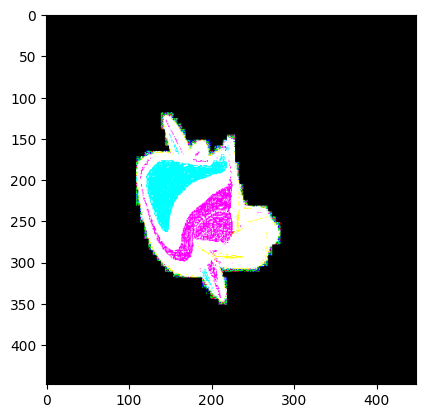

In [7]:
plt.imshow(imgs[0])

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU

X_train=imgs/255

def build_encoder(latent_dimension):
    encoder = Sequential()
    
    encoder.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(448, 448, 3)))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))
    
    encoder.add(Conv2D(256, (3, 3), padding='same', activation=LeakyReLU()))
    encoder.add(BatchNormalization())
    encoder.add(MaxPooling2D((2, 2)))

    encoder.add(Flatten())
    encoder.add(Dense(latent_dimension, activation='tanh'))
    
    return encoder

In [16]:
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
def build_decoder(latent_dimension):
    decoder = Sequential()
    decoder.add(Dense(7*7*64, activation='tanh', input_shape=(latent_dimension,)))
    decoder.add(Reshape((7, 7, 64)))
    decoder.add(Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    #decoder.add(UpSampling2D((2, 2)))
    decoder.add(Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid'))
    return decoder

In [17]:
encoder = build_encoder(latent_dimension=200)


In [18]:
decoder = build_decoder(latent_dimension=200)

In [19]:
encoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 448, 448, 32)      896       
                                                                 
 batch_normalization_4 (Batc  (None, 448, 448, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 224, 224, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization_5 (Batc  (None, 224, 224, 64)     256       
 hNormalization)                                                 
                                                      

In [20]:
decoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 32)       18464     
 ranspose)                                                       
                                                      

In [21]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
def build_autoencoder(encoder, decoder):
    inp = Input((448, 448, 3))
    encoded = encoder(inp)
    decoded = decoder(encoded)
    autoencoder = Model(inp, decoded)
    return autoencoder

autoencoder = build_autoencoder(encoder, decoder)

In [22]:
def compile_autoencoder(autoencoder):
    autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

compile_autoencoder(autoencoder)
autoencoder.fit(X_train, X_train, epochs=1000, batch_size=32, callbacks=[es], verbose=1)


In [ ]:
prediction = autoencoder.predict(X_train, verbose=0, batch_size=32)# you can now display an image to see it is reconstructed well
    

In [ ]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    ax1.imshow((prediction[i] * 255).astype(np.uint8))
    ax2.imshow(X_train[i].reshape(448, 448, 3))
    plt.show()

In [1]:
print('hello')

hello
